# $f_0$ and $f_1$ frequency monitoring

## Read the data from folder 

In [44]:
import os
import json

# Define the folder containing the files
folder_path = "Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_Ramsey_calibrations"

# Lists to store the extracted data
list_freqs = []
list_triplets = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Skip if not a file
    if not os.path.isfile(file_path):
        continue

    # Read the file and process its contents
    with open(file_path, 'r') as file:
        try:
            # Read lines from the file
            lines = file.readlines()
            # print(lines)
            # Parse the bottom list of lists (second line)
            bottom_list = json.loads(lines[1].strip())
            list_triplets.append(bottom_list)
            # Parse the top list (first line)
            top_list = json.loads(lines[0].strip())
            list_freqs.append(top_list)
            
        except (IndexError, json.JSONDecodeError) as e:
            print(f"Error processing file {filename}: {e}")

# Display the results
print("list_freqs:", len(list_freqs))
print("list_triplets:", len(list_triplets))


Error processing file ramsey_calibration_triplet_Wait300_Shots250_609.228_20240915_2206.txt: list index out of range
Error processing file ramsey_calibration_triplet_Wait300_Shots250_620.657_20240915_2214.txt: list index out of range
list_freqs: 1040
list_triplets: 1040


## Plot $f_0$ and $f_1$ and Magnetic field 

Files processed: 264
list_freqs: 264
list_triplets: 264


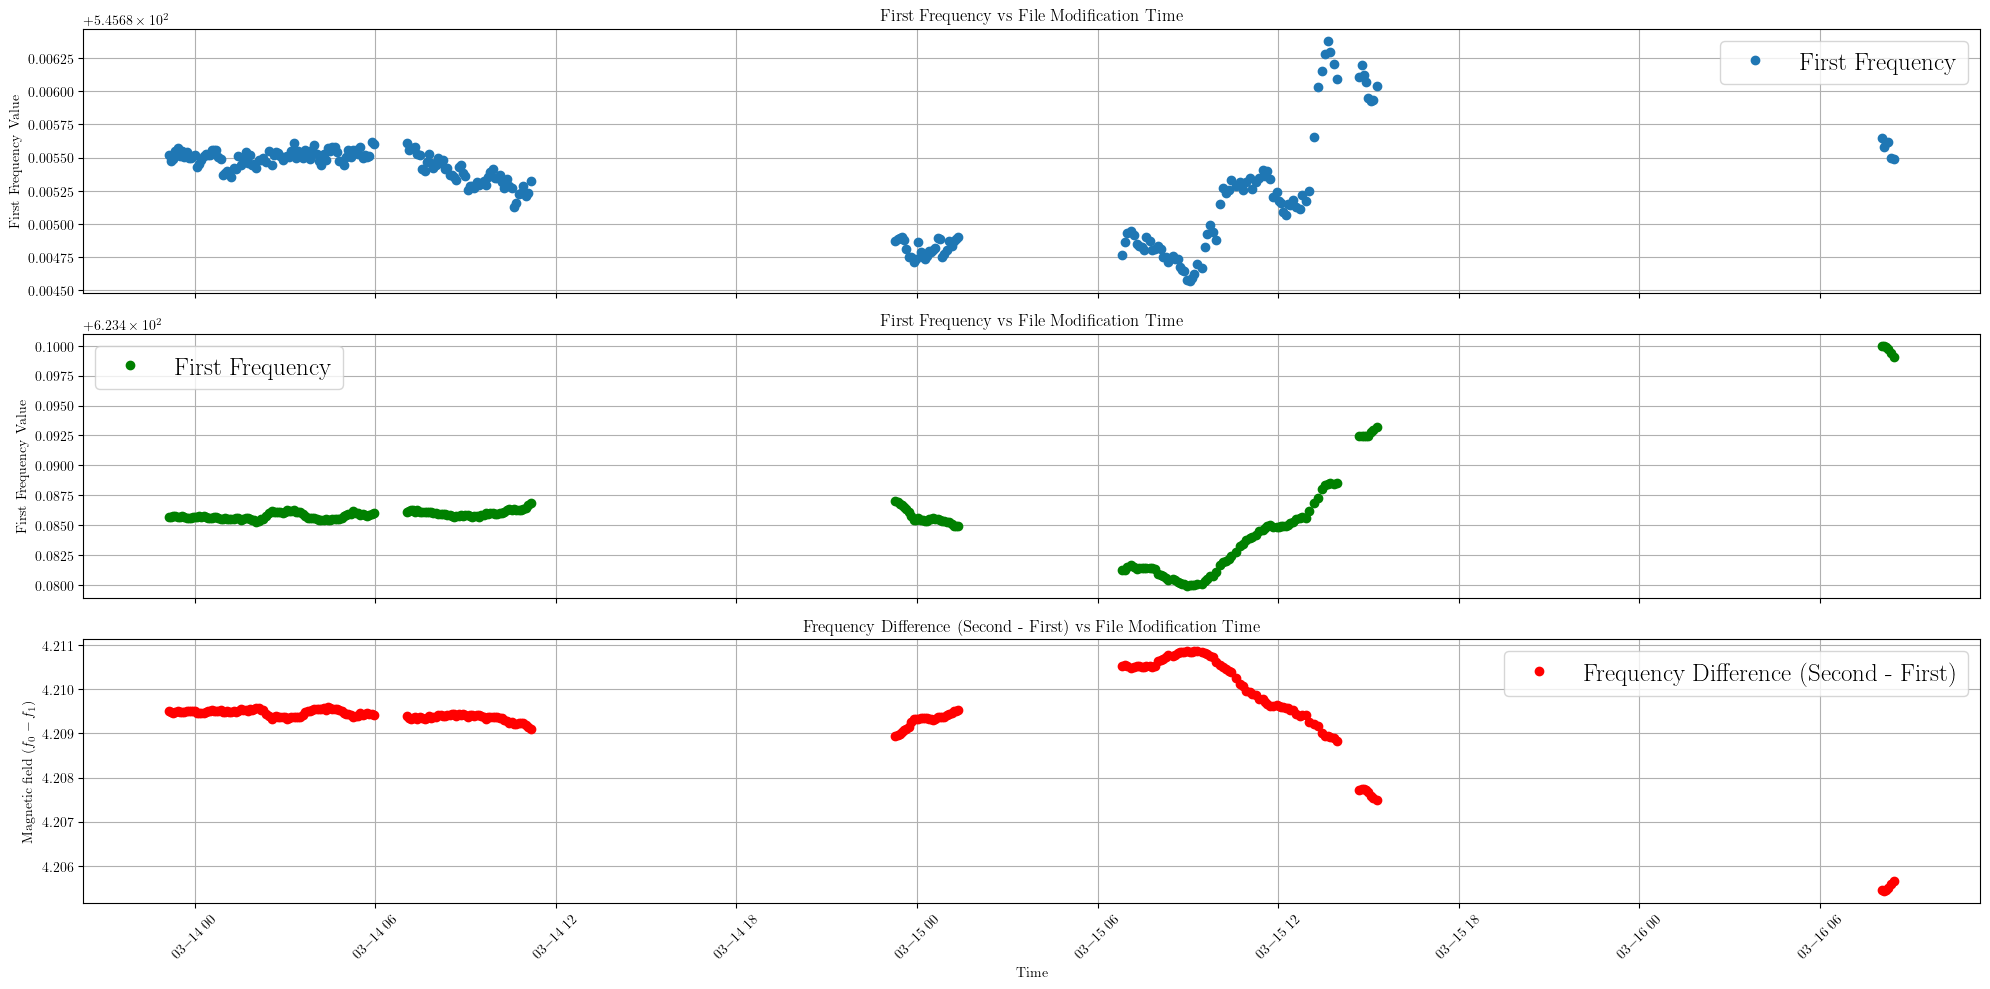

In [50]:
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
# Define the folder containing the files
folder_path = "Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_Ramsey_calibrations"

# Define date-time filter (Modify as needed)
start_date = datetime(2025, 3, 1, 0, 0, 0)  # Change to desired start datetime
end_date = datetime(2025, 3, 16, 23, 6, 59)  # Change to desired end datetime (Optional)

# Lists to store the extracted data
list_freqs = []
list_triplets = []
file_times = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Skip if not a file
    if not os.path.isfile(file_path):
        continue

    # Get file modification time
    mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))

    # Check if the file is within the date-time range
    if start_date <= mod_time <= end_date:
        file_times.append(mod_time)  # Store valid file timestamps

        # Read the file and process its contents
        with open(file_path, 'r') as file:
            try:
                # Read lines from the file
                lines = file.readlines()
                # Parse the bottom list of lists (second line)
                bottom_list = json.loads(lines[1].strip())
                list_triplets.append(bottom_list)
                # Parse the top list (first line)
                top_list = json.loads(lines[0].strip())
                list_freqs.append(top_list)

            except (IndexError, json.JSONDecodeError) as e:
                print(f"Error processing file {filename}: {e}")

# Display the results
print("Files processed:", len(file_times))
print("list_freqs:", len(list_freqs))
print("list_triplets:", len(list_triplets))
# print("File modification times:", file_times)

# Sort data by modification time
sorted_data = sorted(zip(file_times, list_freqs), key=lambda x: x[0])
sorted_times, sorted_freqs = zip(*sorted_data) if sorted_data else ([], [])

# Extract first and second frequency values
first_freq_values = [freq[0] for freq in sorted_freqs if len(freq) > 1]
second_freq_values = [freq[1] for freq in sorted_freqs if len(freq) > 1]

# Compute the difference between the second and first frequencies
freq_differences = np.array([second - first for first, second in zip(first_freq_values, second_freq_values)])/(-3.498)
freq_differences = 4.2095 + freq_differences - freq_differences[0]
# Create a single figure with subplots
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# Plot First Frequency vs. Time
ax[0].plot(sorted_times, first_freq_values, 'o', label="First Frequency")
ax[0].set_ylabel("First Frequency Value")
ax[0].set_title("First Frequency vs File Modification Time")
ax[0].grid(True)
ax[0].legend()
ax[1].plot(sorted_times, second_freq_values, 'go', label="First Frequency")
ax[1].set_ylabel("First Frequency Value")
ax[1].set_title("First Frequency vs File Modification Time")
ax[1].grid(True)
ax[1].legend()
# Plot Difference between Second and First Frequency vs. Time
ax[2].plot(sorted_times, freq_differences, 'o', color='r', label="Frequency Difference (Second - First)")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Magnetic field ($f_0 - f_1$)")
ax[2].set_title("Frequency Difference (Second - First) vs File Modification Time")
ax[2].grid(True)
ax[2].legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()


Files processed: 4
Data points read: 64753
Binned data points: 2159


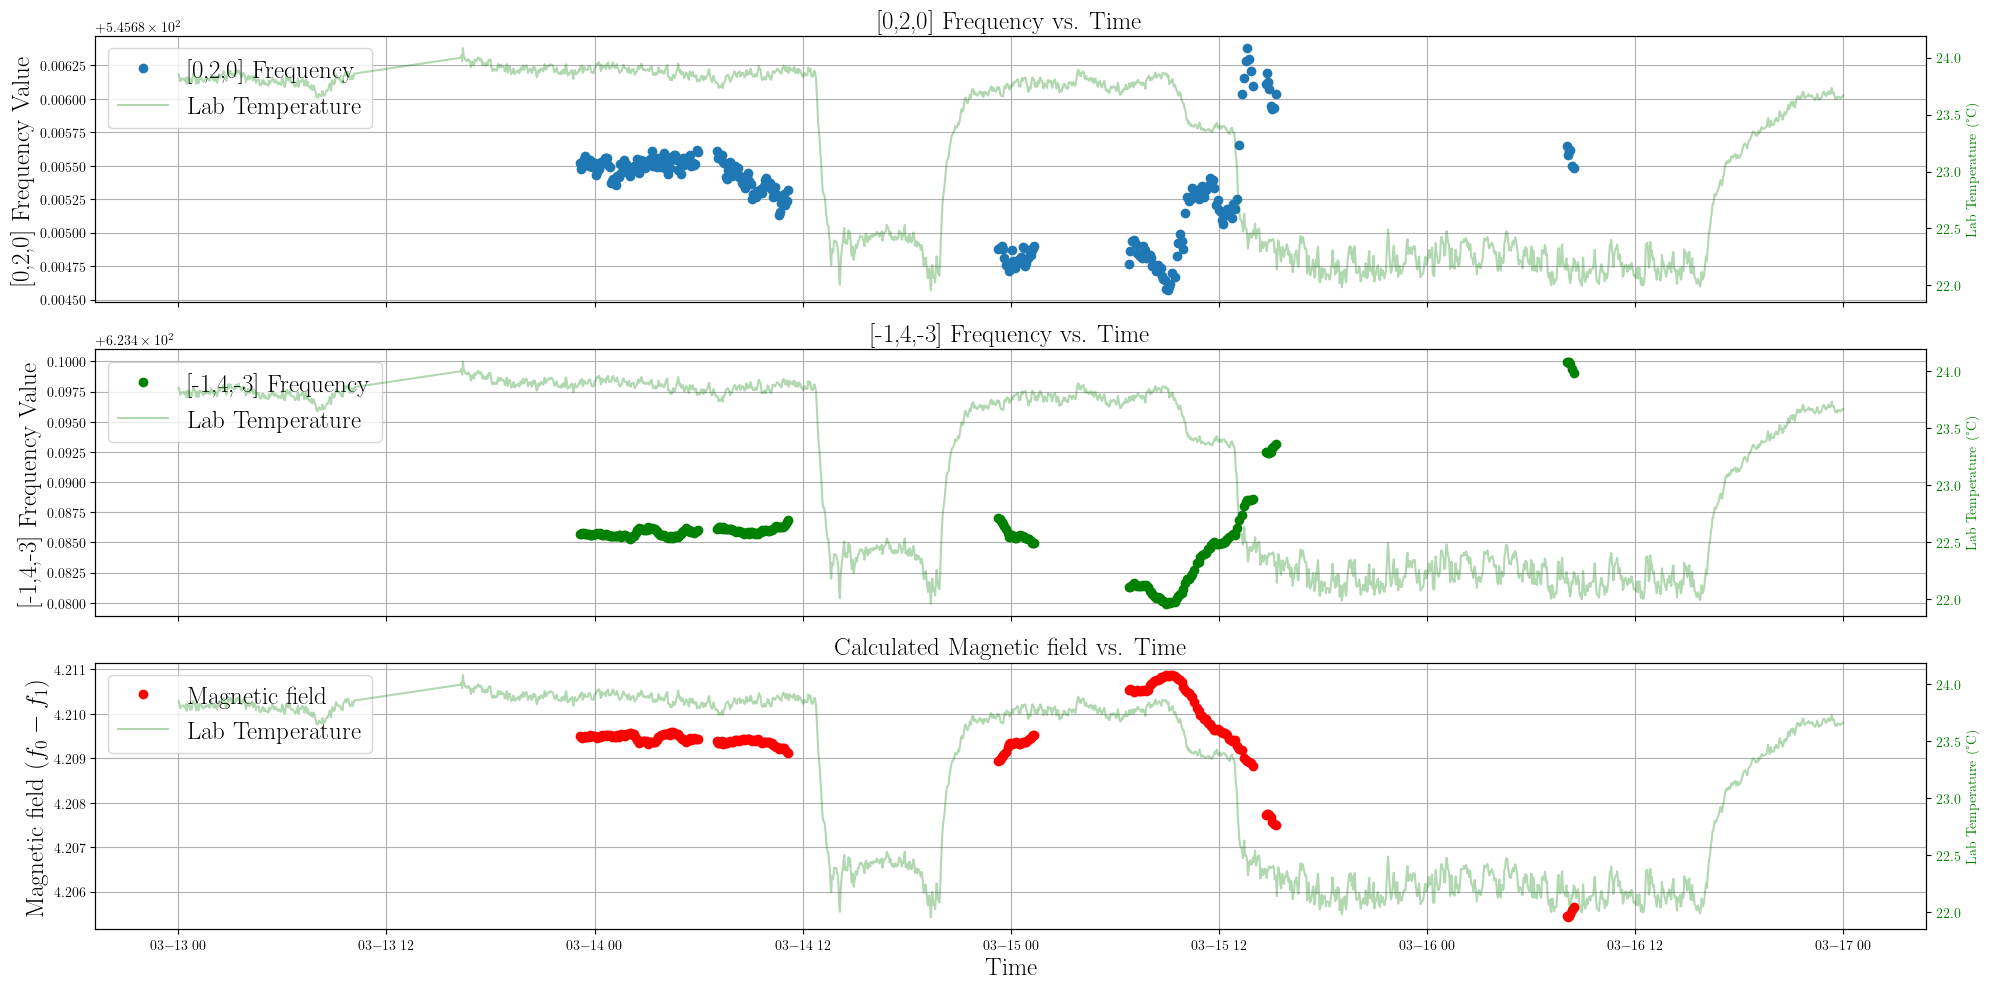

In [58]:
import os
import datetime
from datetime import timedelta

# Function to generate file paths given a start and end date (in "YYYY_MM_DD" format)
def generate_file_paths(start_date_str, end_date_str):
    """
    Generate file paths for lab data files over a date range.
    Files are assumed to be named as "YYYY_MM_DD.txt" and located in a folder structure like:
    "Z:\temperature_log\Temp_open\YYYY_MM\YYYY_MM_DD.txt"
    """
    start_date = datetime.datetime.strptime(start_date_str, '%Y_%m_%d')
    end_date = datetime.datetime.strptime(end_date_str, '%Y_%m_%d')
    file_paths = []
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y_%m_%d')
        month_str = current_date.strftime('%Y_%m')
        file_path = rf"Z:\temperature_log\Temp_open\{month_str}\{date_str}.txt"
        file_paths.append(file_path)
        current_date += timedelta(days=1)
    return file_paths

# Function to read data from the files
def read_data(file_paths):
    """
    Reads lab temperature log files.
    Each file is expected to have lines in the format:
       HH:MM:SS - temperature
    The temperature is assumed to be in °C.
    
    Returns:
        times: list of datetime objects
        temperatures: list of temperature values (floats)
    """
    times = []
    temperatures = []
    for file_path in file_paths:
        base_name = os.path.basename(file_path)
        date_str = base_name.split('.')[0]
        try:
            file_date = datetime.datetime.strptime(date_str, "%Y_%m_%d").date()
        except Exception as e:
            print(f"Error parsing date from filename {base_name}: {e}")
            continue

        # Open the file and read line by line
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    try:
                        time_str, temp_str = line.strip().split(' - ')
                        # Combine the date from the filename with the time from the file
                        datetime_str = f"{file_date} {time_str}"
                        time_obj = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
                        temperature = float(temp_str)
                        times.append(time_obj)
                        temperatures.append(temperature)
                    except ValueError:
                        # Handle lines that don't match the expected format
                        print(f"Skipping line: {line.strip()} (invalid format)")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
    return times, temperatures

# Function to bin the data into chunks of n points
def bin_data(times, temperatures, n):
    """
    Bin the data by averaging every n points.
    Returns:
        binned_times: list of datetime objects (the midpoint of each bin)
        binned_temperatures: list of average temperatures for each bin
    """
    binned_times = []
    binned_temperatures = []
    
    for i in range(0, len(temperatures), n):
        chunk_times = times[i:i+n]
        chunk_temps = temperatures[i:i+n]
        if len(chunk_temps) == 0:
            continue
        
        avg_time = chunk_times[len(chunk_times) // 2]  # Use the middle time as representative
        avg_temp = sum(chunk_temps) / len(chunk_temps)
        binned_times.append(avg_time)
        binned_temperatures.append(avg_temp)
    
    return binned_times, binned_temperatures

# ----- Main Data Reading Section -----
# Specify the date range for reading the lab temperature logs
file_paths = generate_file_paths("2025_03_13", "2025_03_16")

# Read the data from the files
times, temperatures = read_data(file_paths)

# Optionally, bin the data (for example, average every 60 points)
n = 30
binned_times, binned_temperatures = bin_data(times, temperatures, n)

# For demonstration, print out some basic info:
print("Files processed:", len(file_paths))
print("Data points read:", len(times))
print("Binned data points:", len(binned_times))
lab_temp_times = binned_times
lab_temp_values = binned_temperatures
# If desired, you can then use these lists to plot your data.
# (Plotting code would go here, or you can call your plot_temperature function.)
# ----- Plotting: Overlay Frequency (or Difference) with Lab Temperature on Twin Axes -----
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# ----- Subplot 1: First Frequency vs. Time -----
ax[0].plot(sorted_times, first_freq_values, 'o', label="[0,2,0] Frequency")
ax[0].set_ylabel("[0,2,0] Frequency Value", fontsize = 18)
ax[0].set_title("[0,2,0] Frequency vs. Time", fontsize = 18)
ax[0].grid(True)

# Add lab temperature as a second y-axis (alpha=0.3)
ax0_temp = ax[0].twinx()
line_temp0, = ax0_temp.plot(lab_temp_times, lab_temp_values, 'g-', alpha=0.3, label="Lab Temperature")
ax0_temp.set_ylabel("Lab Temperature (°C)", color='g')
ax0_temp.tick_params(axis='y', labelcolor='g')

# Combine legends for subplot 0
lines0, labels0 = ax[0].get_legend_handles_labels()
lines0_temp, labels0_temp = ax0_temp.get_legend_handles_labels()
ax[0].legend(lines0 + lines0_temp, labels0 + labels0_temp, loc='upper left')

# ----- Subplot 2: Second Frequency vs. Time -----
ax[1].plot(sorted_times, second_freq_values, 'go', label="[-1,4,-3] Frequency")
ax[1].set_ylabel("[-1,4,-3] Frequency Value", fontsize = 18)
ax[1].set_title("[-1,4,-3] Frequency vs. Time", fontsize = 18)
ax[1].grid(True)

# Add lab temperature as a second y-axis for subplot 1
ax1_temp = ax[1].twinx()
line_temp1, = ax1_temp.plot(lab_temp_times, lab_temp_values, 'g-', alpha=0.3, label="Lab Temperature")
ax1_temp.set_ylabel("Lab Temperature (°C)", color='g')
ax1_temp.tick_params(axis='y', labelcolor='g')

# Combine legends for subplot 1
lines1, labels1 = ax[1].get_legend_handles_labels()
lines1_temp, labels1_temp = ax1_temp.get_legend_handles_labels()
ax[1].legend(lines1 + lines1_temp, labels1 + labels1_temp, loc='upper left')

# ----- Subplot 3: Frequency Difference vs. Time -----
ax[2].plot(sorted_times, freq_differences, 'o', color='r', label="Magnetic field")
ax[2].set_xlabel("Time", fontsize = 18)
ax[2].set_ylabel("Magnetic field ($f_0 - f_1$)", fontsize = 18)
ax[2].set_title("Calculated Magnetic field vs. Time", fontsize = 18)
ax[2].grid(True)

# Add lab temperature as a second y-axis for subplot 2
ax2_temp = ax[2].twinx()
line_temp2, = ax2_temp.plot(lab_temp_times, lab_temp_values, 'g-', alpha=0.3, label="Lab Temperature")
ax2_temp.set_ylabel("Lab Temperature (°C)", color='g')
ax2_temp.tick_params(axis='y', labelcolor='g')

# Combine legends for subplot 2
lines2, labels2 = ax[2].get_legend_handles_labels()
lines2_temp, labels2_temp = ax2_temp.get_legend_handles_labels()
ax[2].legend(lines2 + lines2_temp, labels2 + labels2_temp, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Mag_field_temperature.svg')
plt.show()


In [15]:
# list_freqs

# 2-point Calibratipon data analysis

## Reading files

In [3]:
import os
import json
from datetime import datetime

# Define the folder containing the files
folder_path = "Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_Ramsey_calibrations"

# Define date-time filter (Modify as needed)
start_date = datetime(2025, 3, 1, 0, 0, 0)  # Change to desired start datetime
end_date = datetime(2025, 6, 25, 11, 6, 59)  # Change to desired end datetime (Optional)

# Lists to store the extracted data
list_freqs = []
list_triplets = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Skip if not a file
    if not os.path.isfile(file_path):
        continue

    # Get file modification time
    mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))

    # Check if the file is within the date-time range
    if mod_time < start_date or mod_time > end_date:
        continue  # Skip files outside the range

    # Read the file and process its contents
    with open(file_path, 'r') as file:
        try:
            # Read lines from the file
            lines = file.readlines()
            # Parse the bottom list of lists (second line)
            bottom_list = json.loads(lines[1].strip())
            list_triplets.append(bottom_list)
            # Parse the top list (first line)
            top_list = json.loads(lines[0].strip())
            list_freqs.append(top_list)

        except (IndexError, json.JSONDecodeError) as e:
            print(f"Error processing file {filename}: {e}")

# Display the results
print("Files processed:", len(list_freqs))
print("list_freqs:", len(list_freqs))
print("list_triplets:", len(list_triplets))



Files processed: 522
list_freqs: 522
list_triplets: 522


In [5]:
import numpy as np

combined = list(zip(list_freqs, list_triplets))

# Sort combined lists based on the third entry in lists inside list_triplets
combined.sort(key=lambda x: x[1][2])

# Unzip sorted lists back into separate lists
list_freqs, list_triplets = zip(*combined)

# Convert back to lists (if needed)
list_freqs = list(list_freqs)
list_triplets = list(list_triplets)
# Display the results
# print("list_freqs:", list_freqs)
print("list_triplets:", np.array(list_triplets))

list_triplets: [[[ 0  2  0]
  [-1  4 -3]
  [-2  1 -1]]

 [[ 0  2  0]
  [-1  4 -3]
  [-2  1 -1]]

 [[ 0  2  0]
  [-1  4 -3]
  [-2  1 -1]]

 ...

 [[ 0  2  0]
  [-1  4 -3]
  [ 2  4  4]]

 [[ 0  2  0]
  [-1  4 -3]
  [ 2  4  4]]

 [[ 0  2  0]
  [-1  4 -3]
  [ 2  4  4]]]


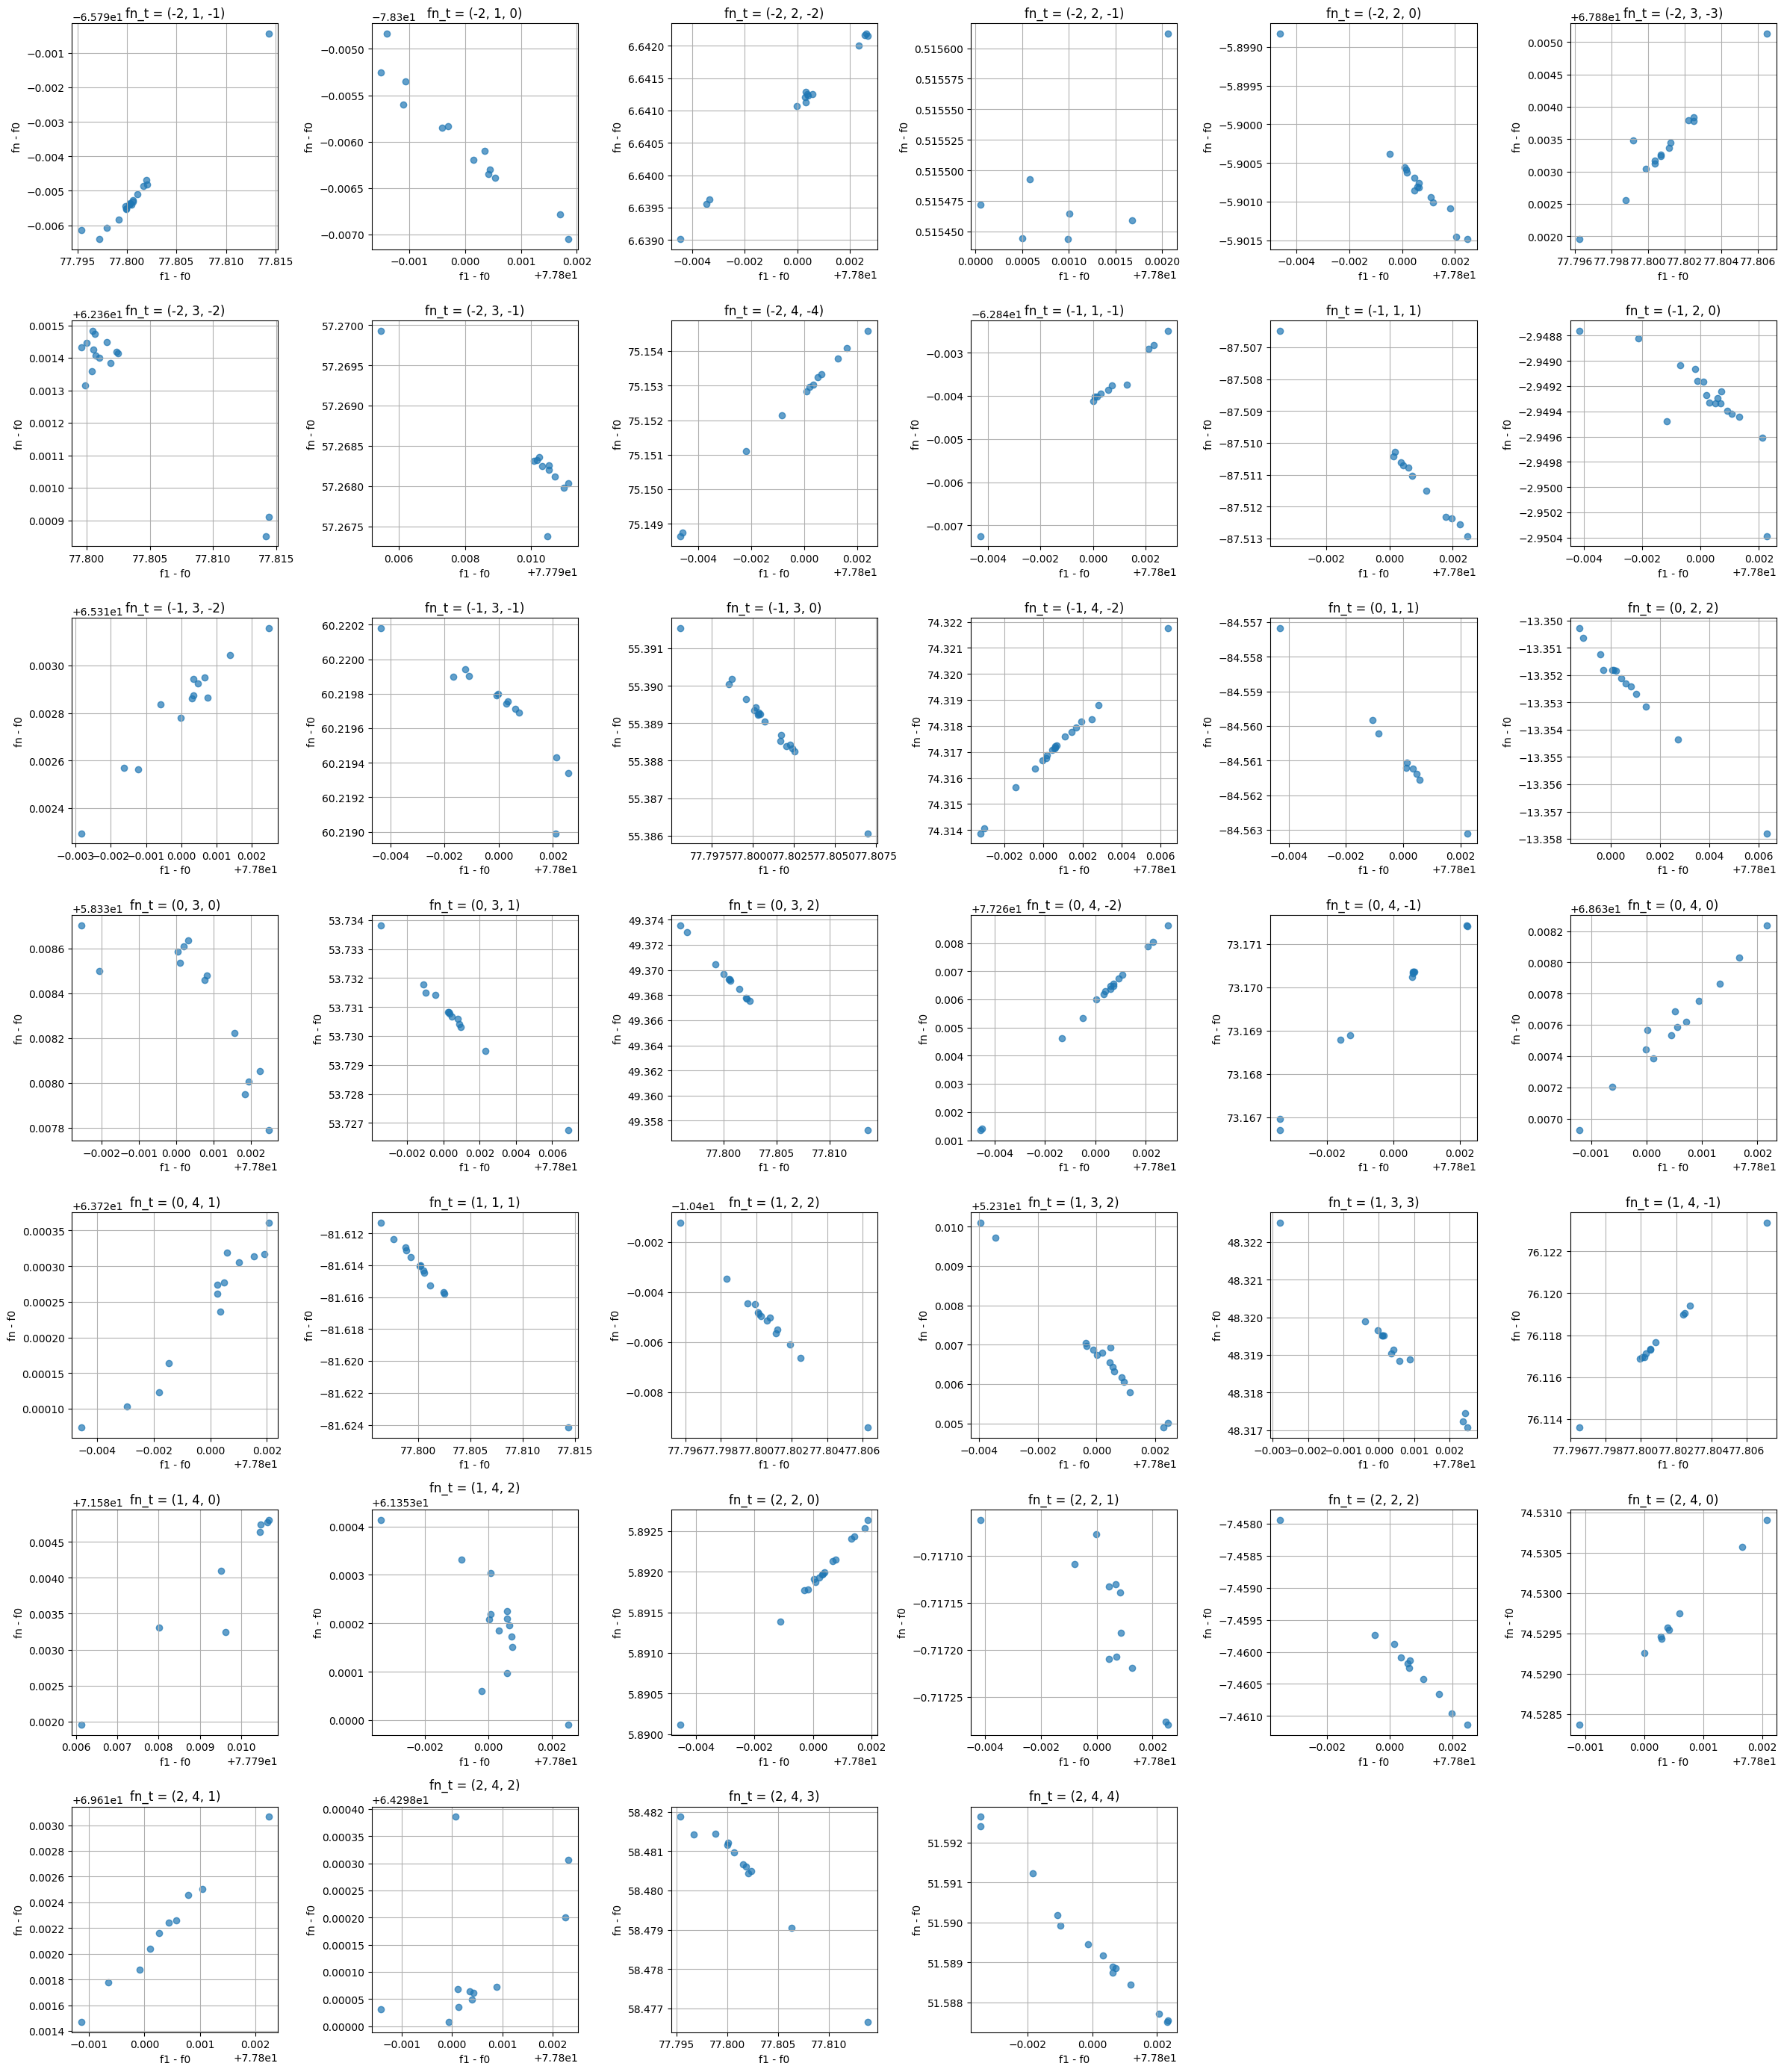

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure list_freqs and list_triplets exist from the previous script
# Unique third entries from list_triplets (fn_t values)
unique_fn_t = sorted(set(tuple(triplet[2]) if isinstance(triplet[2], list) else triplet[2] for triplet in list_triplets))

# Number of columns for the subplot grid
columns = 6
rows = (len(unique_fn_t) + columns - 1) // columns

# Create a grid of subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))
axes = axes.flatten()

for i, fn_t in enumerate(unique_fn_t):
    x_vals = []
    y_vals = []

    # Filter corresponding entries for the current fn_t
    for freqs, triplet in zip(list_freqs, list_triplets):
        current_fn_t = tuple(triplet[2]) if isinstance(triplet[2], list) else triplet[2]
        if current_fn_t == fn_t:
            f0, f1, fn = freqs
            x_vals.append(f1 - f0)
            y_vals.append(fn - f0)

    # Convert to numpy arrays for plotting
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.scatter(x_vals, y_vals, alpha=0.7)
    ax.set_title(f"fn_t = {fn_t}")
    ax.set_xlabel("f1 - f0")
    ax.set_ylabel("fn - f0")
    ax.grid(True)

# Hide any unused subplots
for j in range(len(unique_fn_t), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
from scipy.io import loadmat

mat_data = loadmat('sensitivity_matrix_4p2095G.mat')

matrix_sen_24x5 = mat_data['S']

matrix_sen_24x5[matrix_sen_24x5 == 0] = np.nan
def get_sen(transitions,matrix = matrix_sen_24x5):
    pi_times_list = []
    col_labels = [-2, -1, 0, 1, 2]
    for transition in transitions:
        row_label = [transition[1],transition[2]]
        Fs = [1,2,3,4]
        states = []
        for i in Fs:
            for j in range(2*i+1):
                mF = i-j
                states.append([i,mF])
    
        row_labels = states
    
        col_label = transition[0]
    
        # Find the index of the row label
        row_index = next((i for i, label in enumerate(row_labels) if label == row_label), None)
        # Find the index of the column label
        col_index = col_labels.index(col_label)
        
        if row_index is not None and col_index in range(len(col_labels)):
            pi_times_list.append(matrix[row_index, col_index])
        else:
            pi_times_list.append(np.nan)

    return pi_times_list


get_sen([[0,2,0],[-1,4,-3],[-2,4,-4]],matrix_sen_24x5)

[4.416961019160226e-05, -3.4992355858776136, -2.7992489776806906]

In [11]:
an1_mat = (matrix_sen_24x5 - get_sen([[0,2,0]])[0])/(get_sen([[-1,4,-3]])[0] -  get_sen([[0,2,0]])[0])

In [13]:
an1_mat[np.isnan(matrix_sen_24x5)] = np.nan
an1_mat

array([[-1.30673584, -1.10597322, -0.90550534, -0.70533123, -0.50544991],
       [-0.49900425, -0.29824163, -0.09777375,  0.10240037,  0.30228168],
       [ 0.35536794,  0.55613057,  0.75659845,  0.95677256,  1.15665388],
       [-1.33201265, -1.13125003, -0.93078215, -0.73060804, -0.53072672],
       [-0.85966886, -0.65890624, -0.45843836, -0.25826425, -0.05838293],
       [-0.4012305 , -0.20046788, -0.        ,  0.20017411,  0.40005543],
       [ 0.03259306,  0.23335568,  0.43382356,  0.63399767,  0.83387899],
       [ 0.42089545,  0.62165807,  0.82212595,  1.02230007,  1.22218138],
       [-1.60053842, -1.3997758 , -1.19930792, -0.99913381, -0.79925249],
       [-1.31611622, -1.11535359, -0.91488571, -0.7147116 , -0.51483029],
       [-1.01233016, -0.81156754, -0.61109966, -0.41092555, -0.21104423],
       [-0.69741582, -0.4966532 , -0.29618532, -0.09601121,  0.10387011],
       [-0.37346279, -0.17270017,  0.02776771,  0.22794182,  0.42782314],
       [-0.0380727 ,  0.16268993,  0.3

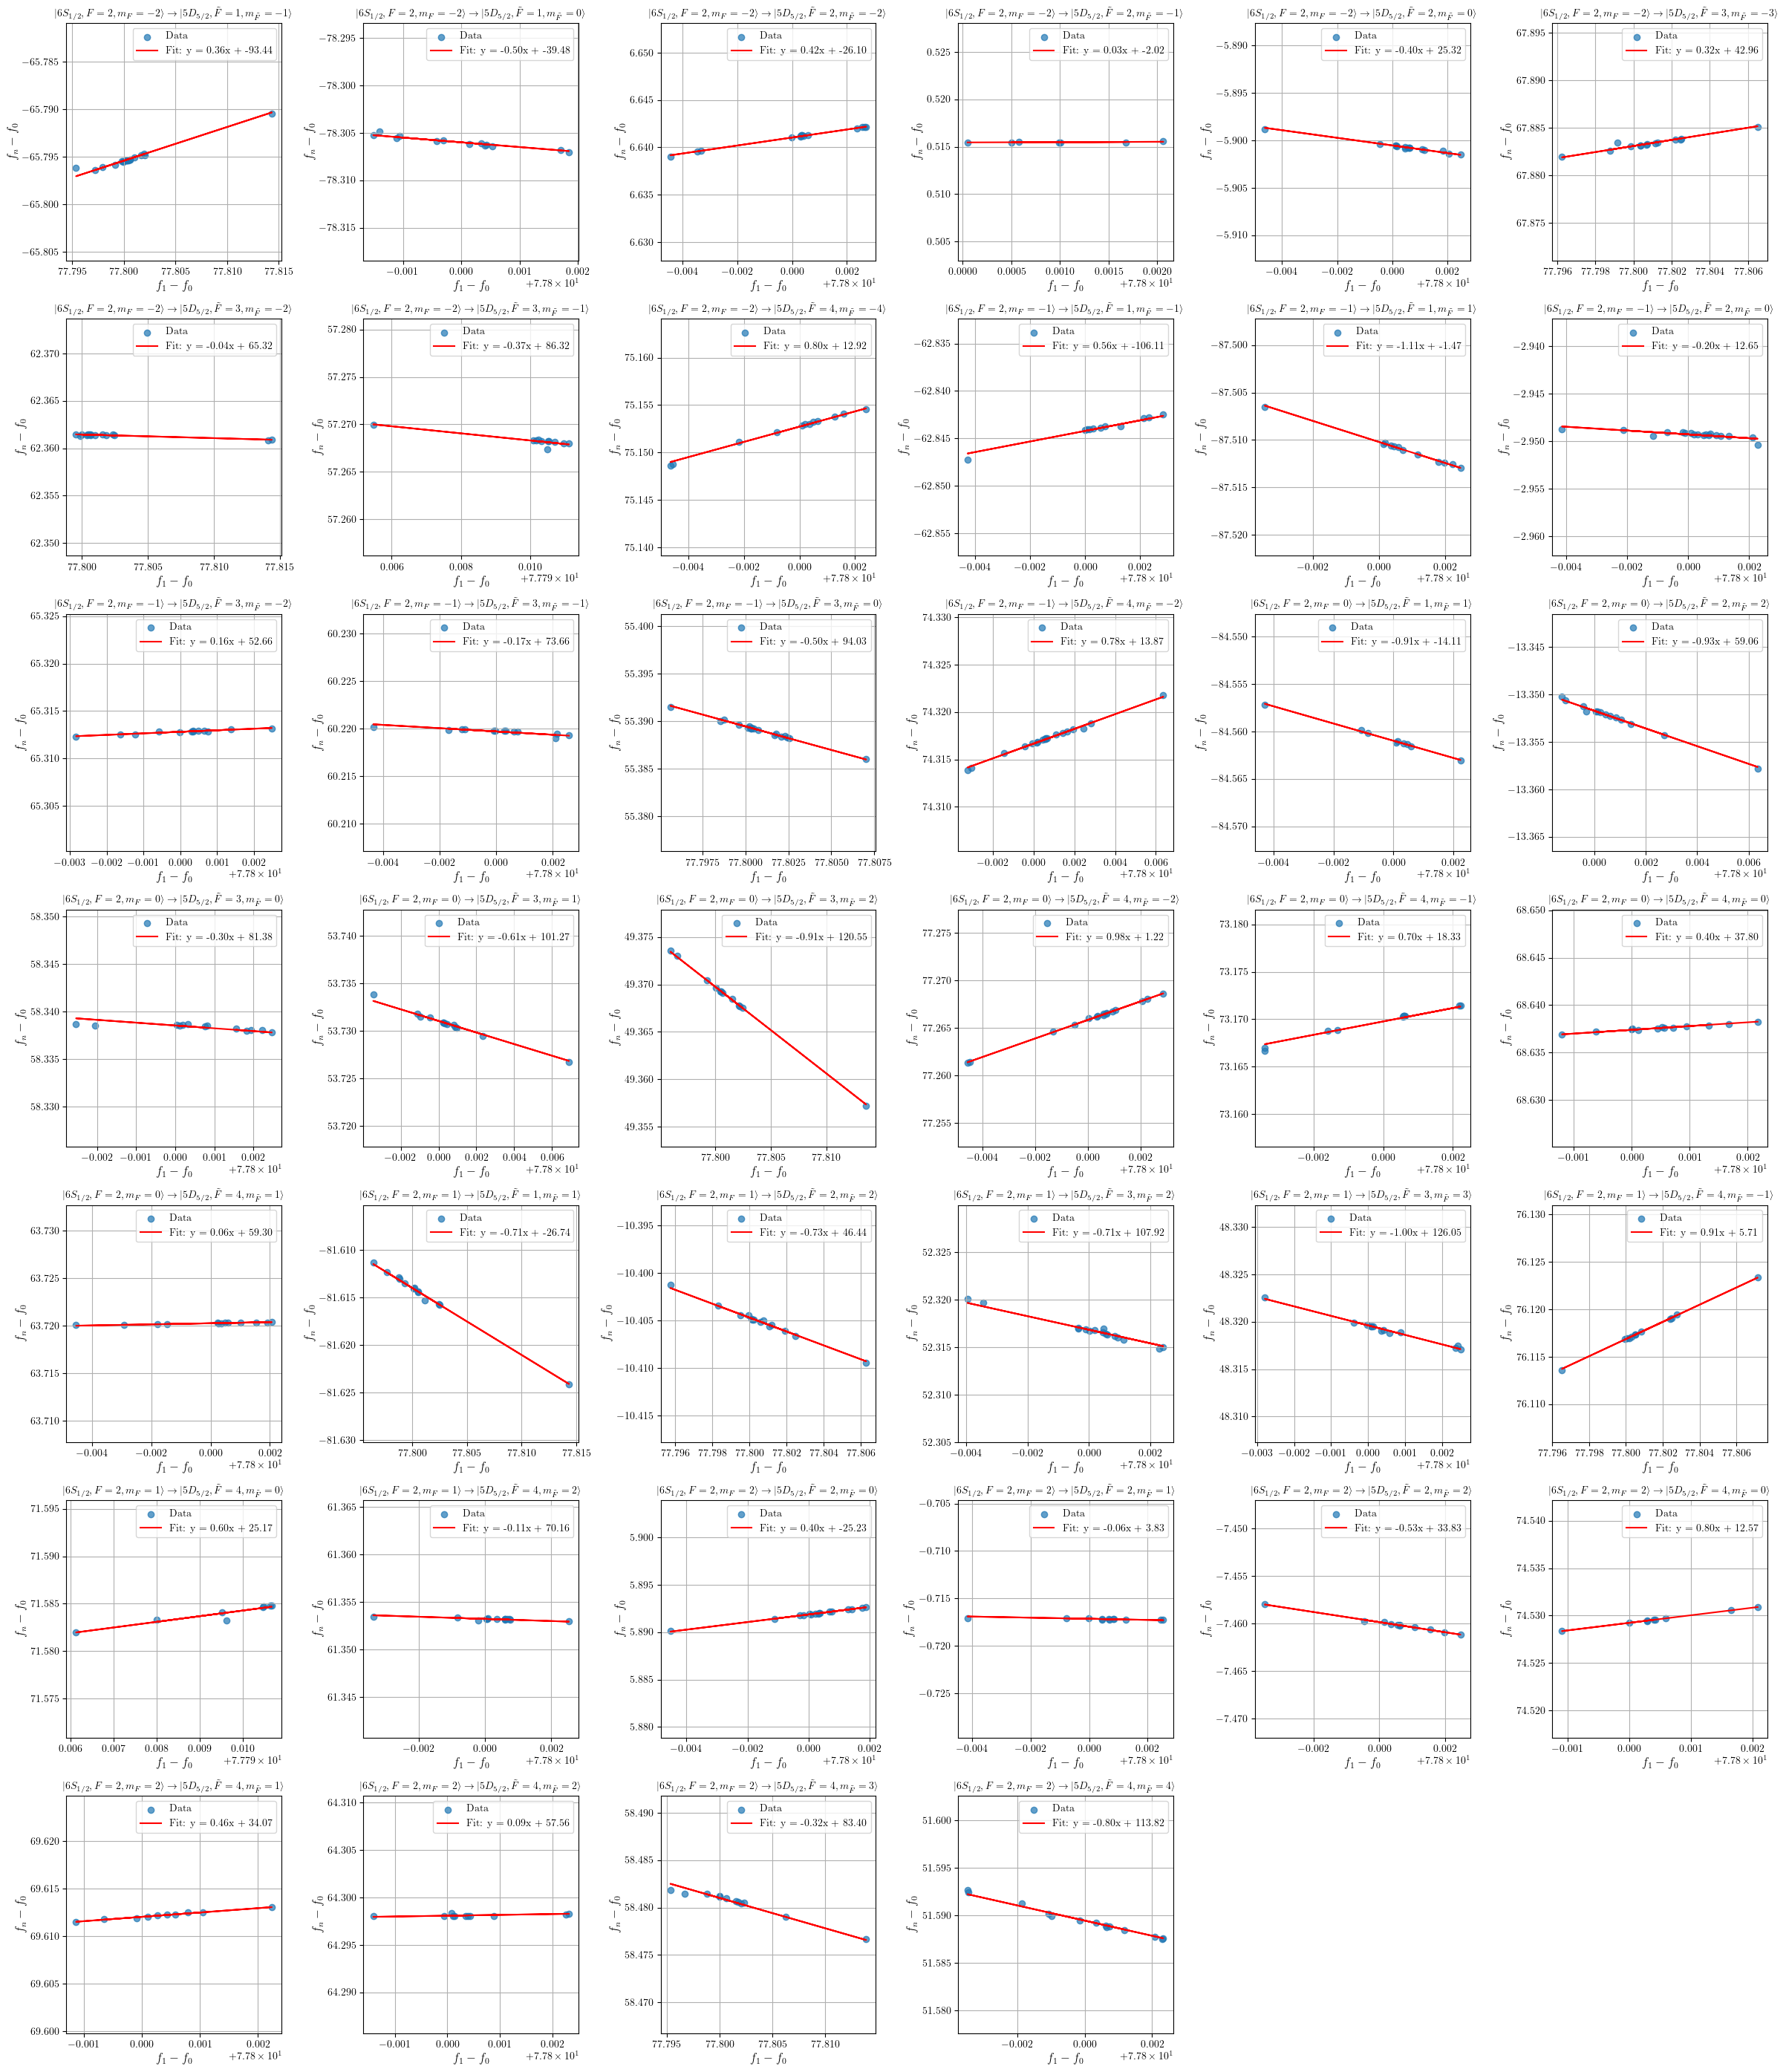

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import numpy as np
from scipy.optimize import curve_fit

# Ensure list_freqs and list_triplets exist from the previous script
# Unique third entries from list_triplets (fn_t values)
unique_fn_t = sorted(set(tuple(triplet[2]) if isinstance(triplet[2], list) else triplet[2] for triplet in list_triplets))

# Function to fit: y = m*x + b, where m is the known slope
def linear_model(x, b, m):
    return m * x + b

# Number of columns for the subplot grid
columns = 6
rows = (len(unique_fn_t) + columns - 1) // columns

# Create a grid of subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))
axes = axes.flatten()
y_ranges = []

trans_list = []
an2_list = []
deviations = []
for i, fn_t in enumerate(unique_fn_t):
    x_vals = []
    y_vals = []

    # Filter corresponding entries for the current fn_t
    for freqs, triplet in zip(list_freqs, list_triplets):
        current_fn_t = tuple(triplet[2]) if isinstance(triplet[2], list) else triplet[2]
        if current_fn_t == fn_t:
            f0, f1, fn = freqs
            x_vals.append(f1 - f0)
            y_vals.append(fn - f0)

    # Convert to numpy arrays for plotting and fitting
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    y_ranges.append(max(y_vals)-min(y_vals))
    # Get the slope from the function for the current triplet
    # print(fn_t)
    slope = get_sen([list(fn_t)],an1_mat)[0]
    # print(slope)
    # Fit the data to find the y-intercept
    popt, _ = curve_fit(lambda x, b: linear_model(x, b, slope), x_vals, y_vals)
    y_intercept = popt[0]

    fitted_line = linear_model(x_vals, y_intercept, slope)

    deviation = y_vals - fitted_line
    deviations.append(deviation)
    trans_list.append(list(fn_t))
    an2_list.append(y_intercept)
    # Plot in the corresponding subplot
    ax = axes[i]
    ax.scatter(x_vals, y_vals, alpha=0.7, label="Data")
    ax.plot(x_vals, linear_model(x_vals, y_intercept, slope), color='red', label=f"Fit: y = {slope:.2f}x + {y_intercept:.2f}")
    ax.set_title(rf"$|6S_{{1/2}},F=2,m_F = {fn_t[0]}\rangle \rightarrow |5D_{{5/2}},\tilde{{F}}={fn_t[1]}, m_{{\tilde{{F}}}} = {fn_t[2]} \rangle$", fontsize = 10)
    ax.set_xlabel(r"$f_1 - f_0$", fontsize = 12)
    ax.set_ylabel(r"$f_n - f_0$", fontsize = 12)
    ax.set_ylim(min(y_vals) + (max(y_vals)-min(y_vals))/2 - 0.025/2, min(y_vals) + (max(y_vals)-min(y_vals))/2 + 0.025/2)
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(len(unique_fn_t), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# plt.savefig('fitted_calibration_data.png',dpi = 800)
plt.savefig('Example_calibration_data.svg')
plt.show()


In [19]:
len(unique_fn_t)

40

In [17]:
print(np.mean(np.abs(np.concatenate(deviations))))

9.407615865965394e-05


522
Voigt Fit (mu=5.5878239196, sigma=68.4208977894, gamma=21.5584249351)


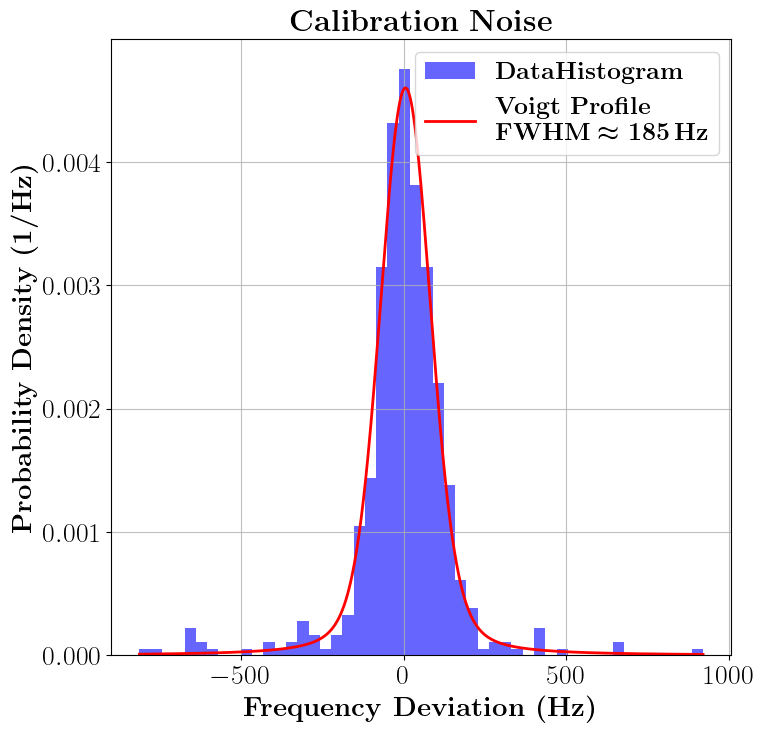

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
# Flatten deviations list
data = np.concatenate(deviations)*10**6
print(len(data))

# Histogram data
counts, bin_edges = np.histogram(data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define wrapper for fitting using scipy's Voigt profile
def voigt_fit_func(x, amp, mu, sigma, gamma):
    return amp * voigt_profile(x - mu, sigma, gamma)

# Initial guess: amp, mu, sigma, gamma
initial_guess = [1, np.mean(data), np.std(data), np.std(data)/2]

sigma_data = np.full_like(bin_centers, 10)  # 10 Hz uncertainty for each bin count

popt, pcov = curve_fit(
    voigt_fit_func,
    bin_centers,
    counts,
    p0=initial_guess,
    sigma=sigma_data,
    absolute_sigma=True
)

amp, mu, sigma, gamma = popt
print(f"Voigt Fit (mu={mu:.10f}, sigma={sigma:.10f}, gamma={gamma:.10f})")

# Plot
plt.figure(figsize = (8,8))
plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label="$\mathbf{Data Histogram}$")

# --- after amp, mu, sigma, gamma are known ---
f_G = 2 * sigma * np.sqrt(2*np.log(2))      # Gaussian FWHM
f_L = 2 * gamma                              # Lorentzian FWHM
fwhm = 0.5346 * f_L + np.sqrt(0.2166*f_L**2 + f_G**2)
# ---------------------------------------------
legend_label = (
    r'\textbf{Voigt Profile}'         # first line, bold text
    '\n'                              # newline
    fr'\textbf{{FWHM}} \boldmath$\approx {fwhm:.0f}\,\mathrm{{Hz}}$'  # second line, LaTeX math
)
x = np.linspace(min(data), max(data), 1000)
plt.plot(x, voigt_fit_func(x, *popt), 'r-', lw=2,
         label=legend_label)#fr'$\mathbf{{Voigt fit (FWHM={fwhm:.2f})}}$')


# x = np.linspace(min(data), max(data), 1000)
# plt.plot(x, voigt_fit_func(x, *popt), 'r-', lw=2,
#          label=rf'Fitted PDF (FWHM \boldmath${}$)')
#=fr"$V(x; \sigma, \gamma) = \dfrac{{\Re\left[w\left(\dfrac{{x + i\gamma}}{{\sigma \sqrt{{2}}}} \right)\right]}}{{\sigma \sqrt{{2\pi}}}}$" + \
      # f"\n$\mu = {mu:.2f}$ Hz, \n $\sigma = {sigma:.2f}$ Hz, \n $\gamma = {gamma:.2f}$ Hz"
plt.xlabel(r"\textbf{Frequency Deviation (Hz)}",  fontsize = 20)
plt.ylabel(r"\textbf{Probability Density (1/Hz)}", fontsize = 20)
plt.title(r"\textbf{Calibration Noise}", fontsize = 22)
plt.tick_params(labelsize = 20)
# plt.yticks([])
plt.legend(loc = 'upper right', fontsize = 18)
plt.grid(alpha = 0.8)
plt.savefig('Calibration_noise.svg')
plt.show()


522
Voigt Fit (mu=5.5878239196, sigma=68.4208977894, gamma=21.5584249351)


100%|██████████| 500/500 [00:00<00:00, 617.62it/s]


Numerical Voigt FWHM = 185.41 ± 0.39 Hz


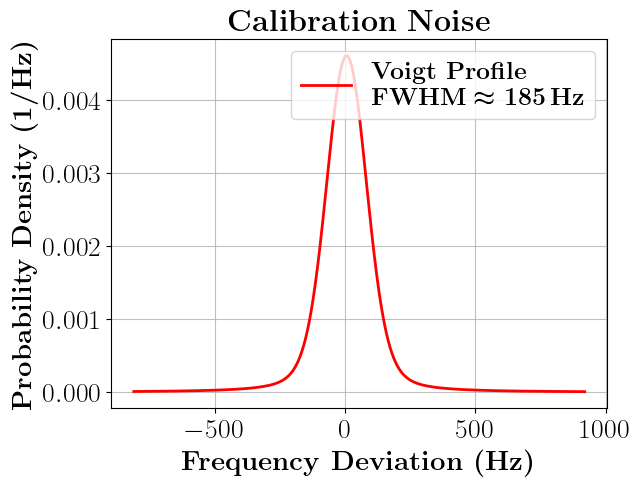

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
# Flatten deviations list
data = np.concatenate(deviations)*10**6
print(len(data))

# Histogram data
counts, bin_edges = np.histogram(data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define wrapper for fitting using scipy's Voigt profile
def voigt_fit_func(x, amp, mu, sigma, gamma):
    return amp * voigt_profile(x - mu, sigma, gamma)

# Initial guess: amp, mu, sigma, gamma
initial_guess = [1, np.mean(data), np.std(data), np.std(data)/2]

sigma_data = np.full_like(bin_centers, 10)  # 10 Hz uncertainty for each bin count

popt, pcov = curve_fit(
    voigt_fit_func,
    bin_centers,
    counts,
    p0=initial_guess,
    sigma=sigma_data,
    absolute_sigma=True
)

amp, mu, sigma, gamma = popt
print(f"Voigt Fit (mu={mu:.10f}, sigma={sigma:.10f}, gamma={gamma:.10f})")

# Extract fit parameters and their uncertainties
amp, mu, sigma, gamma = popt
sigma_amp, sigma_mu, sigma_sigma, sigma_gamma = np.sqrt(np.diag(pcov))

from scipy.stats import norm
import tqdm

n_samples = 500  # Number of bootstrap samples
fwhm_list = []

for _ in tqdm.tqdm(range(n_samples)):
    # Simulate new histogram with noise
    noisy_counts = counts + np.random.normal(0, 10e-6, size=len(counts))

    try:
        # Refit
        popt_i, _ = curve_fit(voigt_fit_func, bin_centers, noisy_counts, p0=initial_guess)
        amp_i, mu_i, sigma_i, gamma_i = popt_i

        # Compute FWHM
        f_G = 2 * sigma_i * np.sqrt(2 * np.log(2))
        f_L = 2 * gamma_i
        fwhm_i = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
        fwhm_list.append(fwhm_i)
    except RuntimeError:
        continue  # Skip bad fits

# Convert to numpy array and calculate standard deviation
fwhm_array = np.array(fwhm_list)
fwhm_mean = np.mean(fwhm_array)
fwhm_std = np.std(fwhm_array)

print(f"Numerical Voigt FWHM = {fwhm_mean:.2f} ± {fwhm_std:.2f} Hz")

x = np.linspace(min(data), max(data), 1000)
plt.plot(x, voigt_fit_func(x, *popt), 'r-', lw=2,
         label=legend_label)#fr'$\mathbf{{Voigt fit (FWHM={fwhm:.2f})}}$')


# x = np.linspace(min(data), max(data), 1000)
# plt.plot(x, voigt_fit_func(x, *popt), 'r-', lw=2,
#          label=rf'Fitted PDF (FWHM \boldmath${}$)')
#=fr"$V(x; \sigma, \gamma) = \dfrac{{\Re\left[w\left(\dfrac{{x + i\gamma}}{{\sigma \sqrt{{2}}}} \right)\right]}}{{\sigma \sqrt{{2\pi}}}}$" + \
      # f"\n$\mu = {mu:.2f}$ Hz, \n $\sigma = {sigma:.2f}$ Hz, \n $\gamma = {gamma:.2f}$ Hz"
plt.xlabel(r"\textbf{Frequency Deviation (Hz)}",  fontsize = 20)
plt.ylabel(r"\textbf{Probability Density (1/Hz)}", fontsize = 20)
plt.title(r"\textbf{Calibration Noise}", fontsize = 22)
plt.tick_params(labelsize = 20)
# plt.yticks([])
plt.legend(loc = 'upper right', fontsize = 18)
plt.grid(alpha = 0.8)
plt.savefig('Calibration_noise.svg')
plt.show()


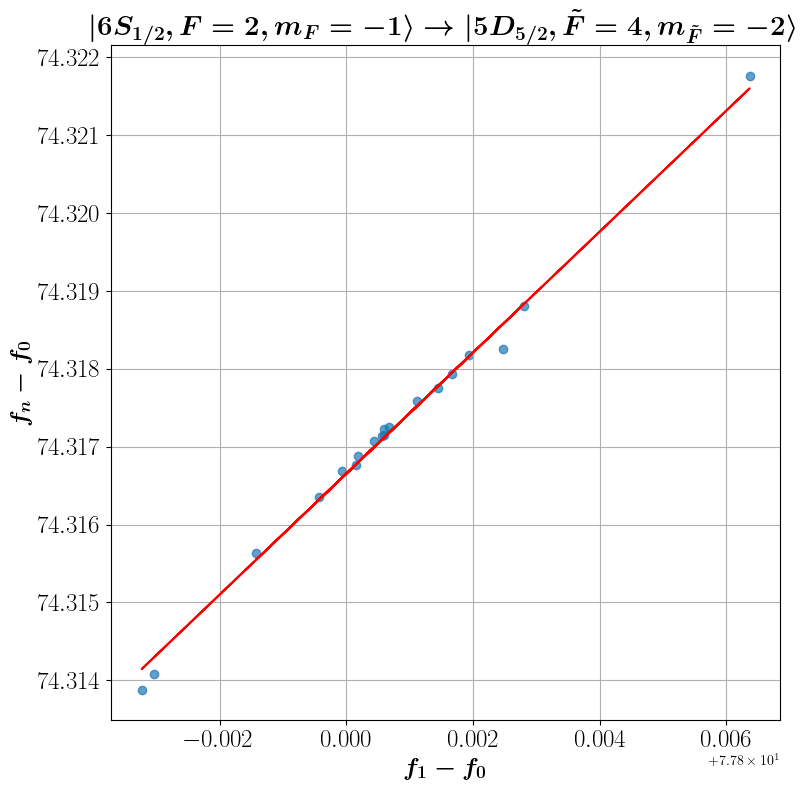

In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.optimize import curve_fit

rcParams['font.family']='serif'
rcParams['font.serif']=['Computer Modern']
rcParams['text.usetex']=True
rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

unique_fn_t=[sorted(set(tuple(tr[2]) if isinstance(tr[2],list) else tr[2] for tr in list_triplets))[15]]
fn_t=unique_fn_t[0]

x_vals=[]
y_vals=[]
for freqs,triplet in zip(list_freqs,list_triplets):
    current_fn_t=tuple(triplet[2]) if isinstance(triplet[2],list) else triplet[2]
    if current_fn_t==fn_t:
        f0,f1,fn=freqs
        x_vals.append(f1-f0)
        y_vals.append(fn-f0)

x_vals=np.array(x_vals)
y_vals=np.array(y_vals)
slope=get_sen([list(fn_t)],an1_mat)[0]
popt,_=curve_fit(lambda x,b: slope*x+b,x_vals,y_vals)
y_intercept=popt[0]

fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_vals,y_vals,alpha=0.7)
ax.plot(x_vals,slope*x_vals+y_intercept,color='red')
ax.set_title(rf"\boldmath$|6S_{{1/2}},F=2,m_F={fn_t[0]}\rangle\rightarrow|5D_{{5/2}},\tilde{{F}}={fn_t[1]},m_{{\tilde{{F}}}}={fn_t[2]}\rangle$",fontsize=20)
ax.set_xlabel(r"\boldmath$f_1-f_0$",fontsize=18)
ax.set_ylabel(r"\boldmath$f_n-f_0$",fontsize=18)
mid=(y_vals.max()+y_vals.min())/2
# ax.set_ylim(mid-0.015/2,mid+0.015/2)
ax.tick_params(labelsize = 18)
ax.grid(True)
plt.tight_layout()
plt.savefig('example_calibration_data.svg')
plt.show()


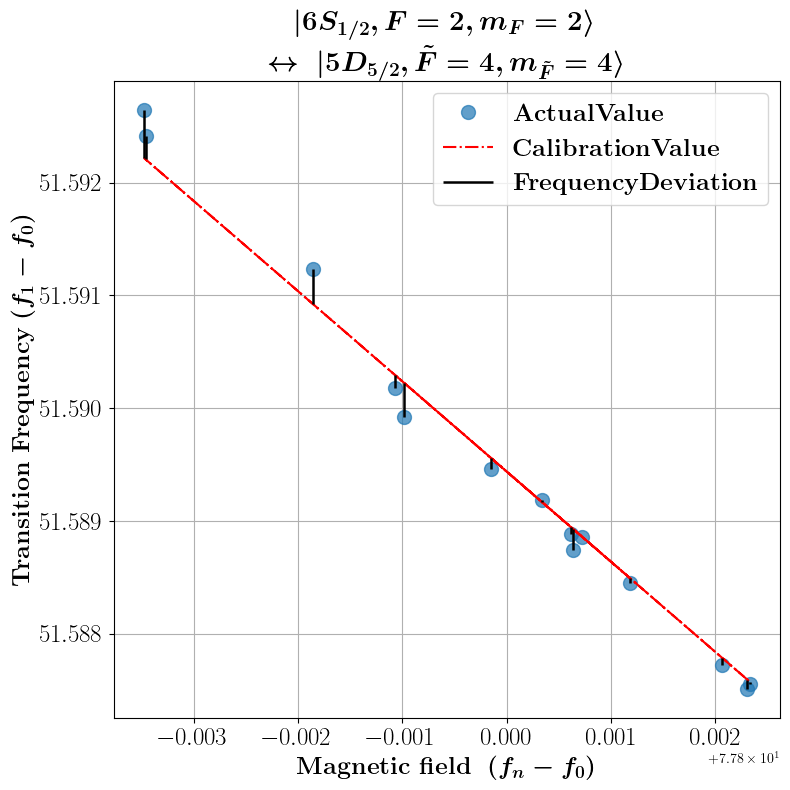

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.optimize import curve_fit

rcParams['font.family']='serif'
rcParams['font.serif']=['Computer Modern']
rcParams['text.usetex']=True
rcParams['text.latex.preamble']=r'\usepackage{amsmath}'
rcParams['legend.fontsize'] = 18
unique_fn_t=[sorted(set(tuple(tr[2]) if isinstance(tr[2],list) else tr[2] for tr in list_triplets))[::-1][0]]
fn_t=unique_fn_t[0]

x_vals=[]
y_vals=[]
for freqs,triplet in zip(list_freqs,list_triplets):
    current_fn_t=tuple(triplet[2]) if isinstance(triplet[2],list) else triplet[2]
    if current_fn_t==fn_t:
        f0,f1,fn=freqs
        x_vals.append(f1-f0)
        y_vals.append(fn-f0)

x_vals=np.array(x_vals)
y_vals=np.array(y_vals)
slope=get_sen([list(fn_t)],an1_mat)[0]
popt,_=curve_fit(lambda x,b: slope*x+b,x_vals,y_vals)
y_intercept=popt[0]
y_fit=slope*x_vals+y_intercept

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(x_vals,y_vals,'o',alpha=0.7,  markersize=10, label = '$\mathbf{Actual Value}$')
ax.plot(x_vals,y_fit,'-.',color='red', label = '$\mathbf{Calibration Value}$')
ax.vlines(x_vals,y_fit,y_vals,color = 'black',alpha=1,lw=1.8, label = "$\mathbf{Frequency Deviation}$")
# ax.set_title(rf"\boldmath$|6S_{{1/2}},F=2,m_F={fn_t[0]}\rangle\rightarrow|5D_{{5/2}},\tilde{{F}}={fn_t[1]},m_{{\tilde{{F}}}}={fn_t[2]}\rangle$",fontsize=16)

ax.set_title(
    rf"\boldmath$|6S_{{1/2}},F=2,m_F={fn_t[0]}\rangle$"  # first line
    "\n"                                                   # break
    rf"\boldmath$\leftrightarrow\ |5D_{{5/2}},\tilde{{F}}={fn_t[1]},m_{{\tilde{{F}}}}={fn_t[2]}\rangle$",
    fontsize=20
)

ax.set_ylabel(r"\textbf{Transition Frequency} \boldmath$(f_1-f_0)$",fontsize=18)
ax.set_xlabel(r"\textbf{Magnetic field } \boldmath$(f_n-f_0)$",fontsize=18)
mid=(y_vals.max()+y_vals.min())/2
ax.tick_params(labelsize=18)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.legend
plt.savefig('example_calibration_data.svg')
plt.show()


In [28]:
import numpy as np
from scipy.special import voigt_profile
import matplotlib.pyplot as plt

# Parameters

def calib_freq_error(n):

    mu = 4.0982368357
    sigma = 0.0034859868
    gamma = 96.4133344970
    
    # Voigt PDF
    def voigt_pdf(x):
        return voigt_profile(x - mu, sigma, gamma)
    
    # Rejection sampling
    def sample_voigt_scipy(num_samples):
        samples = []
        x_min, x_max = mu - 5*gamma, mu + 5*gamma
        x = np.linspace(x_min, x_max, 1000)
        y = voigt_pdf(x)
        ymax = y.max()
    
        while len(samples) < num_samples:
            x_candidate = np.random.uniform(x_min, x_max)
            y_candidate = np.random.uniform(0, ymax)
            if y_candidate < voigt_pdf(x_candidate):
                samples.append(x_candidate)
    
        return np.array(samples)
    return sample_voigt_scipy(n)
# Example: Sample 1000 points
samples = sample_voigt_scipy(100000)

# Optional: Plot the result
x = np.linspace(mu - 300, mu + 300, 1000)
plt.hist(samples, bins=100, density=True, alpha=0.6, label='Sampled')
plt.plot(x, voigt_pdf(x), 'r--', label='True Voigt PDF')
plt.legend()
plt.show()


NameError: name 'sample_voigt_scipy' is not defined

522
Gaussian Fit ($\mu=0.0000000000, \sigma=0.0001538648$)


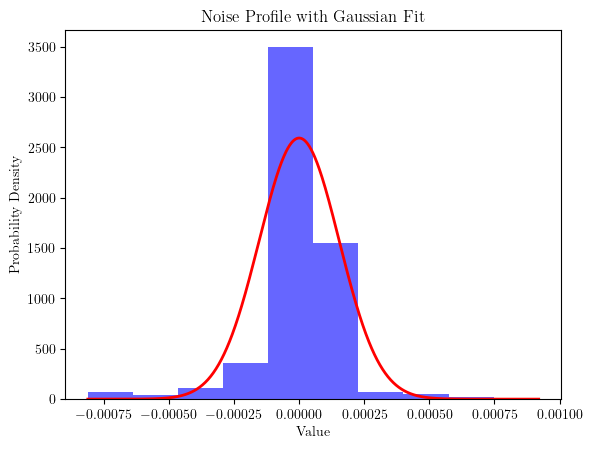

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


data = np.concatenate(deviations)  # Flatten into one dataset
print(len(data))
# Compute histogram and fit Gaussian
mu, sigma = norm.fit(data)  # Fit a normal distribution

# Plot PDF
plt.hist(data, bins=10, density=True, alpha=0.6, color='b', label="Data Histogram")

# Generate Gaussian curve
x = np.linspace(min(data), max(data), 1000)
pdf = norm.pdf(x, mu, sigma)

# Overlay Gaussian fit
plt.plot(x, pdf, 'r-', lw=2, label=f"Gaussian Fit ($\mu={mu:.2f}, \sigma={sigma:.2f}$)")
print(f"Gaussian Fit ($\mu={mu:.10f}, \sigma={sigma:.10f}$)")
# Labels and legend
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Noise Profile with Gaussian Fit")
# plt.legend()
plt.show()


Lorentzian Fit ($x_0=0.0000060, \gamma=0.0000565


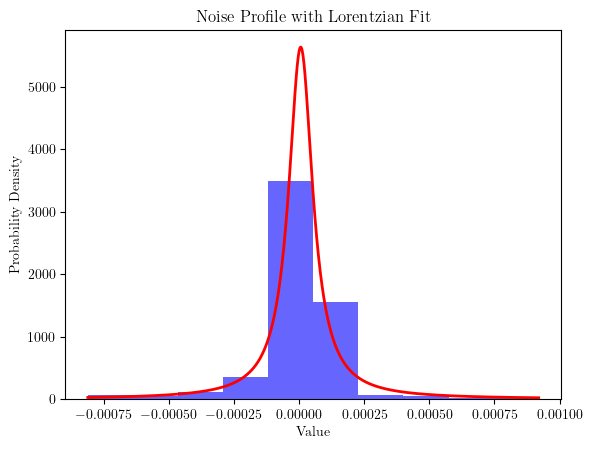

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy


data = np.concatenate(deviations)  # Flatten into one dataset

# Remove extreme outliers (optional, since Cauchy has heavy tails)
data = data[np.abs(data) < 10]  # Truncate extreme values for better visualization

# Fit Cauchy (Lorentzian) distribution
x0, gamma = cauchy.fit(data)

# Plot PDF
plt.hist(data, bins=10, density=True, alpha=0.6, color='b', label="Data Histogram")

# Generate fitted Lorentzian curve
x = np.linspace(min(data), max(data), 1000)
pdf = cauchy.pdf(x, x0, gamma)

# Overlay Lorentzian fit
plt.plot(x, pdf, 'r-', lw=2, label=f"Lorentzian Fit ($x_0={x0:.2f}, \gamma={gamma:.2f}$)")
print(f'Lorentzian Fit ($x_0={x0:.7f}, \gamma={gamma:.7f}')
# Labels and legend
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Noise Profile with Lorentzian Fit")
# plt.legend()
plt.show()


max(y_ranges)

In [75]:
%matplotlib widget

In [104]:
matrix_dummy = np.arange(1, 121).reshape(24, 5)
def fill_matrix(labels,numbers,mat):
    combined_data = zip(labels,numbers)
    for i,j in combined_data:
        index = np.where(matrix_dummy == get_sen([i],matrix_dummy)[0])
        mat[index] =  j
    return mat

In [106]:
nan_mat = np.full((24, 5), np.nan)
print(len(trans_list))
an2_mat = fill_matrix(trans_list,an2_list,nan_mat)

40


In [108]:
print(an2_mat)

[[          nan   -1.46549681  -14.11270864  -26.73920411           nan]
 [ -39.48358889           nan           nan           nan           nan]
 [ -93.44312169 -106.11109907           nan           nan           nan]
 [          nan           nan   59.06311477   46.43653879   33.83066956]
 [          nan           nan           nan           nan    3.82508686]
 [  25.31520223   12.64721871           nan           nan  -25.23246492]
 [  -2.02028886           nan           nan           nan           nan]
 [ -26.10462204           nan           nan           nan           nan]
 [          nan           nan           nan  126.05221065           nan]
 [          nan           nan  120.54788803  107.92138377           nan]
 [          nan           nan  101.27452716           nan           nan]
 [          nan   94.02906179   81.38188367           nan           nan]
 [  86.32380148   73.65587022           nan           nan           nan]
 [  65.32351251   52.65556241           nan        

In [129]:
import numpy as np

# Step 1: Create a 24x5 matrix filled with random numbers
matrix = an2_mat  # Replace this with your matrix if you have one

# Step 2: Save the matrix to a text file
filename = 'Z:\Lab Data\D52_Calibration_Ba137\Calibration_Parameters\\an2_2025.txt'  # Specify the path and filename
np.savetxt(filename, matrix, delimiter='\t', fmt='%f')  # %f for floating point format

print("Matrix saved to", filename)

Matrix saved to Z:\Lab Data\D52_Calibration_Ba137\Calibration_Parameters\an2_2025.txt


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of deviations in milli-units
mean_deviation = np.mean(1000 * np.array(deviations))
print(f"Mean deviation (in kHz): {mean_deviation}")

# Prepare data for plotting
abs_sen_values = np.abs(get_sen(trans_list))
scaled_deviations = 1000 *  np.array(deviations)  # Flatten deviations for all fn_t

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(abs_sen_values, scaled_deviations, 'o', label="Deviations")

# Annotate data points
for i, (x, y) in enumerate(zip(abs_sen_values, scaled_deviations)):
    plt.text(x, y, trans_list[i], fontsize=10, va='top')  # Annotation on the left of the points

# Customize plot
plt.xlabel("|Sen|")
plt.ylabel("Deviation from fitted line [kHz]")
plt.title("Deviation vs Sensitivity")
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors  # For interactive annotations

# Calculate the mean of deviations in milli-units
mean_deviation = np.mean(1000 * np.array(deviations))
print(f"Mean deviation (in kHz): {mean_deviation}")

# Prepare data for plotting
abs_sen_values = np.abs(get_sen(trans_list))
scaled_deviations = 1000 * np.array(deviations)  # Flatten deviations for all fn_t

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.plot(abs_sen_values, scaled_deviations, 'o', label="Deviations")

# Add interactive annotations
cursor = mplcursors.cursor(hover=True)
cursor.connect(
    "add",
    lambda sel: sel.annotation.set_text(
        f"Trans: {trans_list[sel.index]}\nDeviation: {scaled_deviations[sel.index]:.2f} kHz"
    )
)

# Customize plot
ax.set_xlabel("|Sen|")
ax.set_ylabel("Deviation from fitted line [kHz]")
ax.set_title("Deviation vs Sensitivity")
ax.grid(True)
ax.legend()
plt.tight_layout()

# Save the interactive plot as a PDF
fig.savefig("interactive_deviation_plot.pdf", format="pdf")

# Show the plot
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.

In [274]:
pip install mplcursors


Note: you may need to restart the kernel to use updated packages.
